In [1]:
from glob import glob
import os as os
import json
import matplotlib.pyplot as plt  
import matplotlib as mpl  
import autograd.numpy as np
from autograd import grad
import pandas as pd
import scipy as scipy
import time

np.random.seed(123)
%matplotlib inline

import keras as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input
from keras import backend as K
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV

import matplotlib.image as mpimg

Using TensorFlow backend.


In [2]:
subject_annotations = pd.read_table('/home/a0121533/fyp2017dsap/Phase_0/subject_annotations.txt')
sample_annotations = pd.read_table('/home/a0121533/fyp2017dsap/Phase_0/sample_annotations.txt')

sample_id_list = sample_annotations['SAMPID']
sample_id_dict = {}

# Create dictionary of slide names and corresponding row index in sample annotations txt
for i in range(0, len(sample_id_list)):
    sample_id = sample_id_list[i]
    sample_id_shortened = sample_id[0:sample_id.rfind("-", 0, sample_id.rfind("-"))]
    sample_id_dict[sample_id_shortened] = i

In [3]:
sample_attributes_to_predict = ['SMNTRART',
                                'SMMAPRT',
                                'SMEXNCRT',
                                'SMUNMPRT',
                                'SMNTERRT',
                                'SMNTRNRT',
                                'SMMPUNRT',
                                'SMEXPEFF']

tissue_type = ["liver"]

In [4]:
#SMNTRART	Intragenic Rate: The fraction of reads that map within genes (within introns or exons)
#SMMAPRT 	Mapping Rate: Ratio of total mapped reads to total reads
#SMEXNCRT	Exonic Rate: The fraction of reads that map within exons
#SMUNMPRT	Unique Rate of Mapped: Unique reads divided by all mapped reads.
#SMNTERRT	Intergenic Rate: The fraction of reads that map to the genomic space between genes
#SMNTRNRT	Intronic Rate: The fraction of reads that map within introns
#SMMPUNRT	Mapped Unique Rate of Total: Ratio of mapping of reads that were aligned and were not duplicates to total reads
#SMEXPEFF	Expression Profiling Efficiency: Ratio of exon reads to total reads

In [5]:
def get_row_id(data_type):
    read_slides_path = "/home/a0121533/fyp2017dsap/Phase_0/data/normalized/" + data_type + "/" + "liver" + "s/"
    tiles = glob(read_slides_path + "*.png")    
    
    row_id = []
    
    for tile in tiles:
        # read slide name from tile [slide_name]_[slide_index].png score value
        slide_name = tile[tile.rfind('/')+1:tile.rfind('_')]
        row_index = sample_id_dict[slide_name]
        row_id.append(row_index)
    return row_id


train_id = get_row_id("train")
test_id = get_row_id("test")

combined = np.unique(np.asarray(train_id+test_id))

In [6]:
temp1 = ['SMNTRART','SMMAPRT','SMEXNCRT','SMUNMPRT',
        'SMNTERRT','SMNTRNRT', 'SMMPUNRT','SMEXPEFF']

temp2 = ['SAMPID']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
r0 = sample_annotations.iloc[combined][temp2+temp1].dropna()
r1 = scaler.fit_transform(r0[temp1])
r2 = r0[temp2]

reduced = np.hstack((r2,r1))

sample_annotations = pd.DataFrame(reduced,columns=temp2+temp1)

sample_id_list = sample_annotations['SAMPID']
sample_id_dict = {}

# Create dictionary of slide names and corresponding row index in sample annotations txt
for i in range(0, len(sample_id_list)):
    sample_id = sample_id_list[i]
    sample_id_shortened = sample_id[0:sample_id.rfind("-", 0, sample_id.rfind("-"))]
    sample_id_dict[sample_id_shortened] = i

In [7]:
#np.savetxt("liverannotations.txt", sample_annotations, fmt="%s")

In [8]:
def generate_tile_img_matrix(data_type, slide_type, sample_attribute):
    '''
    Iterates through tiles and returns:
    1. NdArray of image matrices 
    2. Array of scores corresponding to tile image
    '''
    read_slides_path = "/home/a0121533/fyp2017dsap/Phase_0/data/normalized/" + data_type + "/" + slide_type + "s/"
    tiles = glob(read_slides_path + "*.png")    
    
    img_matrix_array = []
    scores_array = np.array([])
    
    for tile in tiles:
        # read slide name from tile [slide_name]_[slide_index].png score value
        slide_name = tile[tile.rfind('/')+1:tile.rfind('_')]
        
        if slide_name in sample_id_dict:
            row_index = sample_id_dict[slide_name]

            attr = sample_annotations.iloc[[row_index]][sample_attribute].values[0]
            if not np.isnan(attr):
                row = np.array([attr])
                # append image matrix
                tile_data = mpimg.imread(tile)
                img_matrix_array.append(tile_data)
                scores_array = np.concatenate((scores_array, row))
    
    return np.asarray(img_matrix_array), np.asarray(scores_array)

In [10]:
def encode_data(train_data, test_data):
   
    input_img = Input(shape=(128,128,3), name = 'input_img')
    x = Conv2D(128, (3, 3), activation='elu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='elu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='elu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='elu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    encoded = Flatten()(x)
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='elu',padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='elu',padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='elu',padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='elu',padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='elu',padding='same')(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    #print(autoencoder.summary())
    autoencoder.compile(optimizer='adam', loss='mse')
    encoder = Model(input_img, encoded)
    #print(encoder.summary())
    hfit = autoencoder.fit(x=train_data, y=train_data, epochs=10, batch_size=16, shuffle=True)
    
    decoded_tiles = autoencoder.predict(test_data)
    
    num_tiles = 5  
    plt.figure(figsize=(20, 4))
    for i in range(num_tiles):
        
        ax = plt.subplot(2, num_tiles, i + 1)
        plt.imshow(test_data[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, num_tiles, i + 1 + num_tiles)
        plt.imshow(decoded_tiles[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
    return np.array(encoder.predict(train_data)), np.array(encoder.predict(test_data))

In [11]:
results_dict = {}
for t in tissue_type:
    results_dict[t] = {}
    for s in sample_attributes_to_predict:
        results_dict[t][s] = {"mse_dist": [],
                              "shuffle_mse_dist": []
                             }
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.02,
    height_shift_range=0.02,
    rotation_range=4)

test_datagen = ImageDataGenerator()

In [30]:
from keras.regularizers import l1
from keras import optimizers


def init_model():
    model = Sequential()
    model.add(Dense(1, input_dim=256, 
                    kernel_initializer='normal',
                    activation = 'sigmoid', 
                    activity_regularizer=keras.regularizers.l1(1e-6)))
    model.compile(loss='mse',
                  optimizer=keras.optimizers.SGD(lr=1e-5))
    return model

from scipy import stats

def generate_mse_boxplot(results,t,s):
    plt.figure(figsize=(5,5))
    mse_dist = results[t][s]['mse_dist']
    shuffle_dist = results[t][s]['shuffle_mse_dist']
    plt.boxplot([mse_dist, shuffle_dist], labels=['Informative', 'Non-informative'], showmeans=True)
    plt.title(s, fontsize=20)
    return plt

In [ ]:
def run(tissue):
    np.random.seed(123)
    for sample_attribute in sample_attributes_to_predict:
        print("Obtaining MSE Distribution for", sample_attribute, "of tissue type:", tissue,"\n")
        
        print("Obtaining tile and labels")
        # generate tile and labels
        x_train, y_train = generate_tile_img_matrix("train", tissue, sample_attribute)
        x_test, y_test = generate_tile_img_matrix("test", tissue, sample_attribute)
        
        print("Generating training data")
        for x_batch, y_batch in train_datagen.flow(x_train, y_train, batch_size=x_train.shape[0]):
            x_train = x_batch
            y_train = y_batch
            break 
                    
        print("Generating test data")
        for x_batch, y_batch in test_datagen.flow(x_test, y_test, batch_size=x_test.shape[0]):
            x_test = x_batch
            y_test = y_batch
            break 
        
        print("Fitting Encoder")
        x_train_encoded, x_test_encoded = encode_data(x_train, x_test)
        
        print("Sanity Check")
        print("y_train:", y_train.shape)
        print("y_test:", y_test.shape)
        print("x_train_encoded:", x_train_encoded.shape)
        print("x_test_encoded:", x_test_encoded.shape, "\n")
        
        y_train_correct = y_train.copy()
        train_size = x_train_encoded.shape[0]
        test_size = x_test_encoded.shape[0]
        
        for i in range(30):
            print("Shuffle", str(i+1))
            start_time = time.time()
            
            # split data
            print("Splitting data")
            
            num_train = int(0.9*train_size)
            num_test = int(0.9*test_size)
            
            train_indices = np.random.choice(train_size, num_train, replace=False)
            test_indices = np.random.choice(test_size, num_test, replace=False)
            
            x_train_split = x_train_encoded[train_indices,]
            y_train_split = y_train_correct[train_indices,]
            
            x_test_split = x_test_encoded[test_indices,]
            y_test_split = y_test[test_indices,]
            
            print("Fitting model #1")
            model = init_model()
            mfit = model.fit(x_train_split, y_train_split, epochs=100,
                      batch_size=16, 
                      validation_data=(x_test_split,y_test_split), 
                      shuffle=True)
            
            print("Testing model #1")
            mse = mfit.history["val_loss"][-1]
            results_dict[tissue][sample_attribute]['mse_dist'].append(mse)

            # shuffle y_train to get silly mse
            print("Shuffling y_train")
            print("Before:", y_train_split)
            np.random.shuffle(y_train_split)
            print("After:", y_train_split)
            
            model_ = init_model()
            print("Fitting model #2")
            mfit_ = model_.fit(x_train_split, y_train_split, epochs=100,
                        batch_size=16, verbose=0, 
                       validation_data=(x_test_split,y_test_split),
                       shuffle=True)
            
            print("Testing model #2")
            mse_ = mfit_.history["val_loss"][-1]
            
            results_dict[tissue][sample_attribute]['shuffle_mse_dist'].append(mse_)
            
            print("mse:", str(mse), "mse_:", str(mse_))
            print("time elapsed:", str(time.time()-start_time),"\n")
            
        generate_mse_boxplot(results_dict,"liver",sample_attribute)

Obtaining MSE Distribution for SMNTRART of tissue type: liver 

Obtaining tile and labels
Generating training data
Generating test data
Fitting Encoder
Epoch 1/10
1735/1735 [==============================] - 10s - loss: 0.0418    
Epoch 2/10
1735/1735 [==============================] - 7s - loss: 0.0390     
Epoch 3/10
1735/1735 [==============================] - 7s - loss: 0.0384     
Epoch 4/10
1735/1735 [==============================] - 7s - loss: 0.0381     
Epoch 5/10
1735/1735 [==============================] - 7s - loss: 0.0379     
Epoch 6/10
1735/1735 [==============================] - 7s - loss: 0.0378     
Epoch 7/10
1735/1735 [==============================] - 7s - loss: 0.0377     
Epoch 8/10
1735/1735 [==============================] - 7s - loss: 0.0376     
Epoch 9/10
1735/1735 [==============================] - 7s - loss: 0.0375     
Epoch 10/10
1735/1735 [==============================] - 7s - loss: 0.0374     


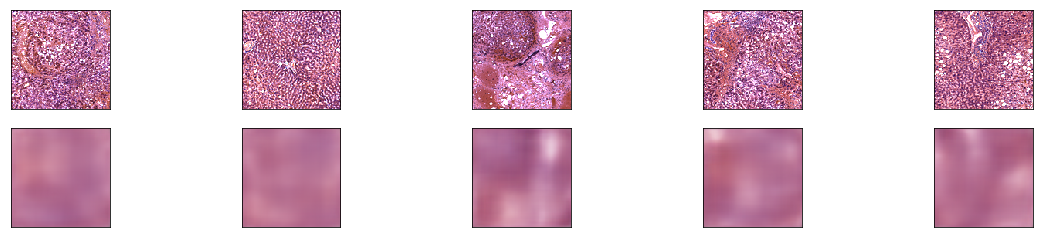

Sanity Check
y_train: (1735,)
y_test: (826,)
x_train_encoded: (1735, 256)
x_test_encoded: (826, 256) 

Shuffle 1
Splitting data
Fitting model #1
Train on 1561 samples, validate on 743 samples
Epoch 1/100
1561/1561 [==============================] - 0s - loss: 0.2673 - val_loss: 0.2481
Epoch 2/100
1561/1561 [==============================] - 0s - loss: 0.2645 - val_loss: 0.2456
Epoch 3/100
1561/1561 [==============================] - 0s - loss: 0.2618 - val_loss: 0.2431
Epoch 4/100
1561/1561 [==============================] - 0s - loss: 0.2590 - val_loss: 0.2405
Epoch 5/100
1561/1561 [==============================] - 0s - loss: 0.2563 - val_loss: 0.2380
Epoch 6/100
1561/1561 [==============================] - 0s - loss: 0.2536 - val_loss: 0.2355
Epoch 7/100
1561/1561 [==============================] - 0s - loss: 0.2509 - val_loss: 0.2330
Epoch 8/100
1561/1561 [==============================] - 0s - loss: 0.2482 - val_loss: 0.2305
Epoch 9/100
1561/1561 [==============================] -

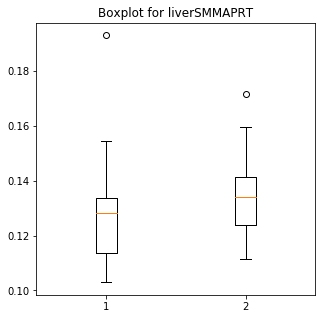

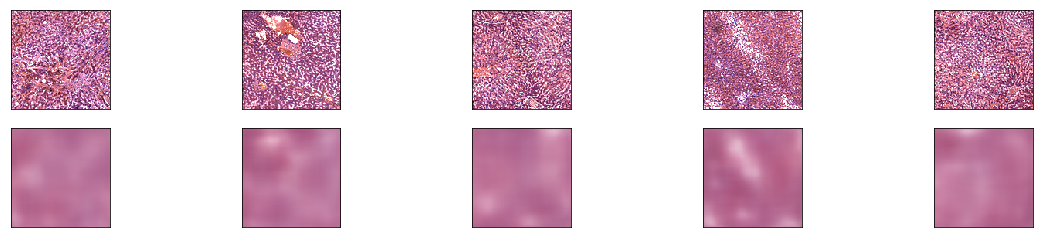

Sanity Check
y_train: (1735,)
y_test: (826,)
x_train_encoded: (1735, 256)
x_test_encoded: (826, 256) 

Shuffle 1
Splitting data
Fitting model #1
Train on 1561 samples, validate on 743 samples
Epoch 1/100
1561/1561 [==============================] - 1s - loss: 0.0569 - val_loss: 0.0931
Epoch 2/100
1561/1561 [==============================] - 0s - loss: 0.0569 - val_loss: 0.0931
Epoch 3/100
1561/1561 [==============================] - 0s - loss: 0.0569 - val_loss: 0.0930
Epoch 4/100
1561/1561 [==============================] - 0s - loss: 0.0569 - val_loss: 0.0930
Epoch 5/100
1561/1561 [==============================] - 0s - loss: 0.0569 - val_loss: 0.0930
Epoch 6/100
1561/1561 [==============================] - 0s - loss: 0.0569 - val_loss: 0.0930
Epoch 7/100
1561/1561 [==============================] - 0s - loss: 0.0569 - val_loss: 0.0929
Epoch 8/100
1561/1561 [==============================] - 0s - loss: 0.0569 - val_loss: 0.0929
Epoch 9/100
1561/1561 [==============================] -

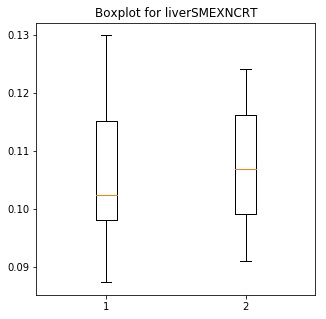

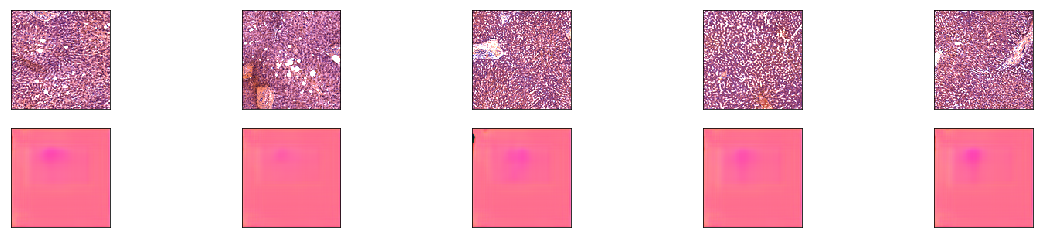

Sanity Check
y_train: (1735,)
y_test: (826,)
x_train_encoded: (1735, 256)
x_test_encoded: (826, 256) 

Shuffle 1
Splitting data
Fitting model #1
Train on 1561 samples, validate on 743 samples
Epoch 1/100
1561/1561 [==============================] - 2s - loss: 0.0194 - val_loss: 0.0525
Epoch 2/100
1561/1561 [==============================] - 0s - loss: 0.0154 - val_loss: 0.0471
Epoch 3/100
1561/1561 [==============================] - 0s - loss: 0.0134 - val_loss: 0.0440
Epoch 4/100
1561/1561 [==============================] - 0s - loss: 0.0126 - val_loss: 0.0423
Epoch 5/100
1561/1561 [==============================] - 0s - loss: 0.0123 - val_loss: 0.0414
Epoch 6/100
1561/1561 [==============================] - 0s - loss: 0.0122 - val_loss: 0.0409
Epoch 7/100
1561/1561 [==============================] - 0s - loss: 0.0122 - val_loss: 0.0406
Epoch 8/100
1561/1561 [==============================] - 0s - loss: 0.0122 - val_loss: 0.0405
Epoch 9/100
1561/1561 [==============================] -

In [ ]:
run("liver")

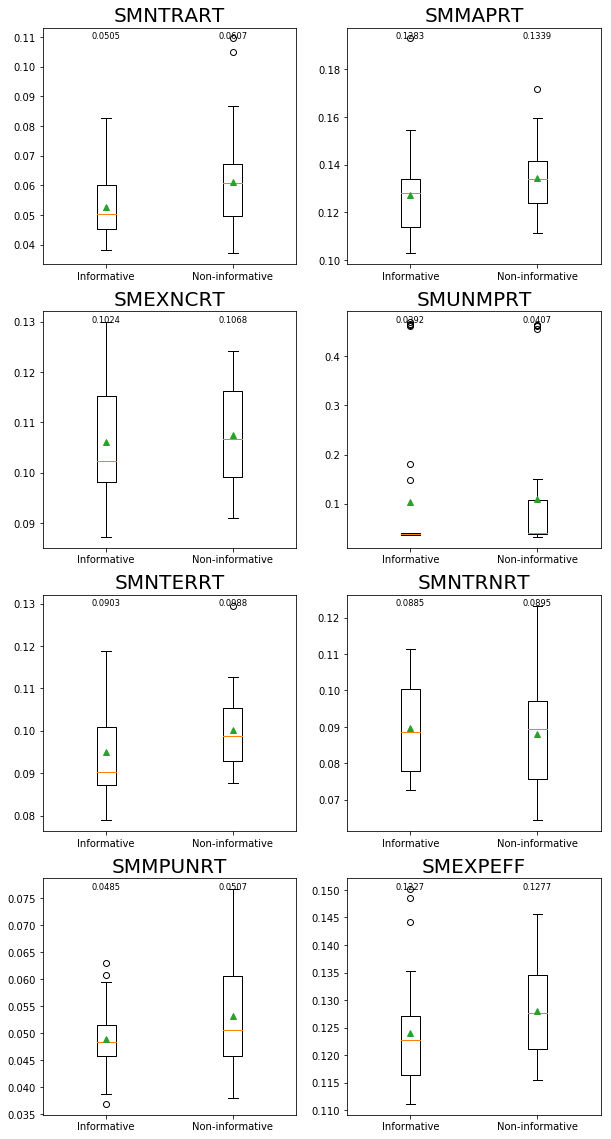

In [77]:
n = 8

plt.figure(figsize=(10, 20))
for i in range(n):
    # plot with various axes scales
    plt.figure(1)

    ax = plt.subplot(4,2,i+1)
    s = sample_attributes_to_predict[i]
    mse_dist = results_dict["liver"][s]['mse_dist']
    shuffle_dist = results_dict["liver"][s]['shuffle_mse_dist']
    
    informative_median = np.median(mse_dist)
    non_informative_median = np.median(shuffle_dist)

    medians = [informative_median,non_informative_median]
    
    plt.boxplot([mse_dist, shuffle_dist], 
                labels=['Informative', 'Non-informative'], 
                showmeans=True)
    
    
    pos = np.arange(2) + 1
    upperLabels = [str(np.round(s, 4)) for s in medians]
    weights = ['bold', 'semibold']
    for tick, label in zip(range(2), ax.get_xticklabels()):
        k = tick % 2
        ax.text(pos[tick], max(mse_dist+shuffle_dist) - ( max(mse_dist+shuffle_dist)*0.000001), upperLabels[tick],
                 horizontalalignment='center', size='small')
    
    plt.title(s, fontsize=20)
    

plt.show()

In [40]:
counter = 0
for s in sample_attributes_to_predict:
    mean_mse_dist = np.mean(results_dict["liver"][s]["mse_dist"])
    shuffle_mse_dist = np.mean(results_dict["liver"][s]["shuffle_mse_dist"])
    if mean_mse_dist < shuffle_mse_dist:
        counter += 1
        print(s+"*", ":", round(mean_mse_dist,4), round(shuffle_mse_dist,4))
    else:
        print(s, ":", round(mean_mse_dist,4), round(shuffle_mse_dist,4))
print(counter, "/", len(sample_attributes_to_predict))

SMNTRART* : 0.0529 0.0612
SMMAPRT* : 0.1273 0.1345
SMEXNCRT* : 0.1061 0.1074
SMUNMPRT* : 0.1039 0.11
SMNTERRT* : 0.0949 0.1003
SMNTRNRT : 0.0896 0.088
SMMPUNRT* : 0.0489 0.0531
SMEXPEFF* : 0.124 0.1281
7 / 8
